In [1]:
import requests
from bs4 import BeautifulSoup
from lxml import etree
import re
import time
import pandas as pd
import os
from google import google
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import matplotlib.font_manager as fm

<font face="微软雅黑" size=5 color=#436EEE > 1. 從google上抓出相關連結

In [2]:
#找出時間的範圍
def get_date_range(date_start,date_end):
    date = []
    start_year = int(date_start.split('/')[0])
    start_month = int(date_start.split('/')[1])
    start_day = int(date_start.split('/')[2])
    end_year = int(date_end.split('/')[0])
    end_month = int(date_end.split('/')[1])
    end_day = int(date_end.split('/')[2])
    date_s = datetime.datetime(start_year,start_month,start_day)
    date_e = datetime.datetime(end_year,end_month,end_day)
    date_range = date_e - date_s
    for i in range(date_range.days+1):
        date.append((date_s+datetime.timedelta(days=i)).strftime("%Y/%m/%d"))
    return date

In [3]:
#關鍵字串以及時間
def get_google(keyword,date_start,date_end,num_page):
    date = get_date_range(date_start,date_end)
    search_link = {}
    for i in range(len(keyword)):
        link_word = []
        for j in range(len(date)):
            keyword_date = keyword[i]+" "+"\""+date[j]+"\""
            search_results = google.search(keyword_date,num_page)
            for k in search_results:
                link_word.append(k.link)
        search_link[keyword[i]] = link_word
    return search_link

In [4]:
keyword = ["洗錢","金融詐欺"]
s = "2019/3/15"
e = "2019/3/17"
link = get_google(keyword,s,e,2)

<font face="微软雅黑" size=5 color=#436EEE > 2. 從連結抓出相關文章

In [5]:
def get_html(url):
    try:
        user_agent = 'Mozilla/5.0'
        resp = requests.get(url, headers={'User-Agent': user_agent}, timeout = 30) #回傳為一個request.Response的物件
        resp.endcoding = 'utf8'
        return resp.text
    except:
        return 'ERROR'

In [6]:
def get_all_text(url):
    text = get_html(url)
    html = etree.HTML(text)
    no_use_content = html.xpath('//*/text()')
    content = str()
    flag = False #不等於中文字的情況
    count = 0 #想要找出是句中標點的東西，1代表是在句子中
    for i in no_use_content:
        for ch in i:
            if (u'\u4e00' >= ch or ch >= u'\u9fff'):
                count += 1
                flag = False
            if (flag == False and count == 1): 
                content += ch
            if not(u'\u4e00' >= ch or ch >= u'\u9fff'):
                count = 0
                flag = True
                content += ch
    content = delete_ad_rough(content)
    char_list = ['!','?','。','\＂','＃','＄','％','＆','＊','＜','＝','＞','\'','：','；',' ','\u3000','\xa0','>','<','_']
    for ch in content:
        if ch in char_list:
            content = content.replace(ch,'。')
    content = content.replace('\r', '。')
    content = content.replace('\t', '。')
    content = content.replace('\n', '。')
    content = content.replace('\"', '。')
    content = content.replace('：', '。')
    return content

In [7]:
#簡易的清除廣告
def delete_ad_rough(content,limit_num=10):
    content_split = content.split(" ") #先將字串切割
    final_content = str()
    for i in content_split:
        if len(i)>limit_num:           #若字數大於10則判斷不為廣告
            final_content+="。"
            final_content+=i
    return final_content
        

In [9]:
%cd /Users/lawrence70726/Desktop/zh-NER-TF-master

/Users/lawrence70726/Desktop/zh-NER-TF-master


In [10]:
#將文章依關鍵字別寫入檔案中
content_list_short = []
w = open("keyword_file.txt", 'w',encoding='UTF-8')
for i in keyword:
    content_list = []
    w.write(i)
    w.write('\n')
    f = open(i + ".txt", "w",encoding='UTF-8')
    for j in link[i]:
        content_list.append(get_all_text(j))
    for k in range(len(content_list)):
        a = content_list[k].strip('。')
        f.write(a)
        f.write("\n")
    f.close()
w.close()

<font face="微软雅黑" size=5 color=#436EEE > 3. 從文章中整理出名字

In [11]:
#匯入模型，從檔案中抓出文章再匯入模型，並將結果再存入檔案中
%run main.py

/Users/lawrence70726/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Namespace(CRF=True, batch_size=64, clip=5.0, demo_model='1521112368', dropout=0.5, embedding_dim=300, epoch=40, hidden_dim=300, lr=0.001, mode='demo', optimizer='Adam', pretrain_embedding='random', shuffle=True, test_data='data_path', train_data='data_path', update_embedding=True)


vocab_size: 3905
./data_path_save/1521112368/checkpoints/model-31680
Instructions for updating:
Colocations handled automatically by placer.


From /Users/lawrence70726/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


From /Users/lawrence70726/Desktop/zh-NER-TF-master/model.py:60: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


From /Users/lawrence70726/Desktop/zh-NER-TF-master/model.py:64: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


From /Users/lawrence70726/Desktop/zh-NER-TF-master/model.py:71: bidirectional_dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


From /Users/lawrence70726/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py:443: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Use tf.cast instead.


From /Users/lawrence70726/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/rnn.py:626: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
/Users/lawrence70726/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


============= demo =============
Instructions for updating:
Use standard file APIs to check for files with this prefix.


From /Users/lawrence70726/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./data_path_save/1521112368/checkpoints/model-31680


Restoring parameters from ./data_path_save/1521112368/checkpoints/model-31680


焦點
焦點
產經
焦點
財經
焦點
金管會
焦點
財經
焦點
金管會
邱金蘭
內文頁
內文頁
關新聞
焦點
金管會
焦點
金管會
建議
願景新
筆記遊
戲國際
鳴人堂
倡議讀
書吧讀
設計
小學
絕對會
財經
焦點相
關新聞
徐國
兩蔣時代
雙子星
易華
擴市場
經濟部
經濟部
電價費
凍漲
於法無據
凍漲
平均電價
實質成長
馬林育生
勤業眾信
發園
國瑜
務實路線
誰沾
劑獲准
邱金蘭
評鑑團
方將
金管會
與評鑑團
經濟
陳明堂
陳明堂
評鑑團會
會議後
預計
金磚數
徐國
中資
實質
經濟部
價凍漲
於法無據
平均電價
實質成長
馬林育生
勤業眾信
發園
國瑜
劑獲准
要小心
宇購
誰沾
差雖
金管
郭董臉書
會澄清
初審通過
實質
國瑜
當企業
馬林育生
拚經濟
稅申
報有變
將發
萬元
價凍漲
鴻海
買賣超
元氣疾
噓星聞
門星聞噓
訊試駕
庫新聞
動特區
權聲明
角國際
鳴人堂
讀小說
點數我
金管會
縮小來
長簡介
華山
保險
申辦
雙語詞彙
關文書
架構
長簡介
華山
保險
申辦
雙語詞彙
關文書
優惠實
專區
關問
瀏覽
管專區
管專區
國華
產險清
理專區
申辦
倫敦
金融
託及財富
銀行業
專責
備註
專區
銀行業
與經濟
制洗錢
專責
銀行業
銀行業
連結
銀行業
專區
北區
詞彙對
本會簡介
申報
爭法規
布時間
競爭政策
統公開
資訊
統計
資料發
布時間
國家廉
約宣導
語音
杜絕
杜絕
關連
會本會簡
時新聞
結合申報
討論傳
銷線上
報備產
暨聯合
行為申
請線
填報系
統公開
資訊重
動公開之
布時間
權利
建議
經允許
申報
填報系
統公開
資訊
統計
資料發
布時間
雙語
詞彙對
常見問
服務
預設
頁籤
滑鼠
相對應
內容並隱
元素
金管會
縮小來
簡介
資訊
金管會
金檢
申報
常見問
業資訊
連結
關連結
簡介
資訊
金管會
金檢
申報
常見問
業資訊
連結
金檢
專區
金檢學堂
機關
簡介
資訊
金管會
金檢
申報
常見問
傳真
電話
金管會
縮小來
長簡歷
申訴
常見問
申辦
雙語詞彙
開戶問
報宣導
長簡歷
申訴
常見問
申辦
雙語詞彙
開戶問
報宣導
常見問
申辦
金管會
紐約
倫敦
金融
實務問
歷史
歷史
巨額利潤
財富
腐蝕各級
納公約
國體認
並於
錢建議
行為
併建議
擊資
於民國
並奉總統
關業務


絲團
莊隆慶臉
莊隆慶
聯光
長林慧鈞
給謝嘉
莊隆慶
隆慶
謝嘉
莊隆慶
謝嘉
聲明
莊隆昌
莊隆慶
莊隆文
隆慶臉書
還發現
關連
鄧福鈞
謝嘉
方沒
全無關
月證交所
遊集團
丁泊逸
侯尊中
經裝
墾丁泊
丁泊逸
侯尊中
聲請
後續將
權保全
金額為
丁渡假村
侯尊中
多達
將原因歸
莊隆慶
擦筆
這樣說
責聲明
隱私權
東森電視
東森電視
東森創
焦點
小時
東森
擴大徵才
金錢爆
時新聞
小時線
社會
團車
李姓男
詐騙電話
李男
李男
李男發
頭數
男子
訊後
李男平
員詐騙
密碼
團成員
李男
李男
將戶頭
農曆
李男
戶頭數
提領
李男
張芳榮
李濤
與機車
騎士噴
搶當
國給
沒畢業
飄逸卻
洩春光
傷男子
亞當夏娃
撒錢
動腦
虛拒開
網友
傳來
內容為
鐵路平
柵欄
洩春光
兩車
墜樓
孫安佐
蘋果徵
轉載
社會
團車
李姓男
詐騙電話
李男
李男
李男發
頭數
男子
訊後
李男平
員詐騙
密碼
團成員
李男
李男
將戶頭
農曆
李男
戶頭數
提領
李男
張芳榮
李濤
與機車
騎士噴
搶當
詐欺補
國給
金門
選將
林書豪
尼克
林書豪
籃板與
繼開張
柯蕭
道奇總
陸續開
資本市
泰國
個團體
進行宗
團結
長賴清德
選登記
蔡英文
內憂心
競爭
塔尼斯
北小編
發聲
媽真
飄逸卻
洩春光
孫安佐
蘋果徵
轉載
金管會
縮小來
本會
金檢
申辦
申請
花蓮震
關係文書
金管會
資訊
關連結
本會
員簡介
金檢
申辦
申請
花蓮震
關係文書
金管會
資訊
關連結
業務
金管會
金管會
資訊
金管
總說明
金管會
洽詢
金檢
申辦
關係文書
金管會
金管會
傳真
金管會
金管會
金管會
資訊
資訊
檢舉
資訊
資訊
點選
金融監
電話
傳真
權保護
瀏覽
專區
頭撒嬌
國際
現正熱
將於
汪志雄
汪志雄
凌友詩
朱冠諭
玉米梗
黃宇綸
個孩子
閻紀宇
潘恆旭
際總經
葉家譽
蔡英
朱冠諭
體報導
林安儒
連珮妤
汪志雄
汪志雄
凌友詩
朱冠諭
蔡英
朱冠諭
什麼
個孩子
閻紀宇
員賈德納
韓國瑜
國民黨
韓冰
夏珍
川普
進黨準備
華為
長孟晚舟
美國正
於中國
惠塔克
計畫
惠塔克說
預計會
孟晚舟
長羅斯
局長瑞伊
長拉梅提
對於美國
訴華為
孟晚舟
協議
孟晚舟
郵報
當惠塔克
總統川普
惠塔克
易協議
定會
干預
於中國
團準備
孟晚舟


張軒睿
夯新聞
郭董曬
權聲明


In [12]:
name_dict = {}
for i in keyword:
    key_name = i+"_PER_name.txt"
    f = open(key_name, "r")
    PER_name = []
    for a in f:
        PER_name.append(a.strip('\n'))
    name_dict[i]=PER_name
    f.close()

洗錢
金融詐欺


In [13]:
print(name_dict)

{'洗錢': ['焦點', '焦點', '產經', '焦點', '財經', '焦點', '金管會', '焦點', '財經', '焦點', '金管會', '邱金蘭', '內文頁', '內文頁', '關新聞', '焦點', '金管會', '焦點', '金管會', '建議', '願景新', '筆記遊', '戲國際', '鳴人堂', '倡議讀', '書吧讀', '設計', '小學', '絕對會', '財經', '焦點相', '關新聞', '徐國', '兩蔣時代', '雙子星', '易華', '擴市場', '經濟部', '經濟部', '電價費', '凍漲', '於法無據', '凍漲', '平均電價', '實質成長', '馬林育生', '勤業眾信', '發園', '國瑜', '務實路線', '誰沾', '劑獲准', '邱金蘭', '評鑑團', '方將', '金管會', '與評鑑團', '經濟', '陳明堂', '陳明堂', '評鑑團會', '會議後', '預計', '金磚數', '徐國', '中資', '實質', '經濟部', '價凍漲', '於法無據', '平均電價', '實質成長', '馬林育生', '勤業眾信', '發園', '國瑜', '劑獲准', '要小心', '宇購', '誰沾', '差雖', '金管', '郭董臉書', '會澄清', '初審通過', '實質', '國瑜', '當企業', '馬林育生', '拚經濟', '稅申', '報有變', '將發', '萬元', '價凍漲', '鴻海', '買賣超', '元氣疾', '噓星聞', '門星聞噓', '訊試駕', '庫新聞', '動特區', '權聲明', '角國際', '鳴人堂', '讀小說', '點數我', '金管會', '縮小來', '長簡介', '華山', '保險', '申辦', '雙語詞彙', '關文書', '架構', '長簡介', '華山', '保險', '申辦', '雙語詞彙', '關文書', '優惠實', '專區', '關問', '瀏覽', '管專區', '管專區', '國華', '產險清', '理專區', '申辦', '倫敦', '金融', '託及財富', '銀行業', '專責', '備註', '專區', '銀行業', '與經濟', '制洗錢', '專責', '銀行業', '銀行業', '連結', '

<font face="微软雅黑" size=5 color=#436EEE > 4. 計算各個名字於文章中出現的比率(模型判讀能力差)

In [14]:
word_count = {}
for j,i in enumerate(list(name_dict.keys())):
    PER_name_count = list(name_dict.values())[j]
    word_count[i] = Counter(PER_name_count).most_common()

In [15]:
word_count 

{'洗錢': [('金管會', 64),
  ('賴清德', 23),
  ('焦點', 22),
  ('康運動', 19),
  ('資訊', 18),
  ('韓國瑜', 17),
  ('專題', 17),
  ('蔡英文', 14),
  ('實務問', 13),
  ('申辦', 12),
  ('連結', 12),
  ('汪志雄', 12),
  ('尚新奇', 12),
  ('范植德', 12),
  ('簡介', 11),
  ('小時', 11),
  ('趙宥寧', 10),
  ('康新奇', 10),
  ('左側', 10),
  ('側文章', 10),
  ('楊金龍', 10),
  ('國瑜', 9),
  ('金管', 9),
  ('制洗錢', 9),
  ('常見問', 9),
  ('電話', 9),
  ('洗錢', 9),
  ('陳明堂', 8),
  ('專區', 8),
  ('金檢', 8),
  ('凌友詩', 8),
  ('朱冠諭', 8),
  ('個孩子', 8),
  ('蔡英', 8),
  ('朱淑娟', 8),
  ('長賴清德', 8),
  ('尚新奇科', 8),
  ('經濟部', 7),
  ('銀行業', 7),
  ('申報', 7),
  ('規問題轉', 7),
  ('報問題', 7),
  ('舉專線', 7),
  ('請來電', 7),
  ('點擊', 7),
  ('東森', 7),
  ('業務', 7),
  ('基金會', 7),
  ('財經', 6),
  ('邱金蘭', 6),
  ('建議', 6),
  ('馬林育生', 6),
  ('評鑑團', 6),
  ('經濟', 6),
  ('玉米梗', 6),
  ('王世堅', 6),
  ('林清詠', 6),
  ('卡數', 6),
  ('發園', 5),
  ('預計', 5),
  ('權聲明', 5),
  ('縮小來', 5),
  ('金融', 5),
  ('歷史', 5),
  ('盧秀燕', 5),
  ('態文明', 5),
  ('師這張燦', 5),
  ('水痘', 5),
  ('補習班', 5),
  ('憂課業趕', 5),
  ('岳母', 5),
  

In [16]:
word_count.values()

dict_values([[('金管會', 64), ('賴清德', 23), ('焦點', 22), ('康運動', 19), ('資訊', 18), ('韓國瑜', 17), ('專題', 17), ('蔡英文', 14), ('實務問', 13), ('申辦', 12), ('連結', 12), ('汪志雄', 12), ('尚新奇', 12), ('范植德', 12), ('簡介', 11), ('小時', 11), ('趙宥寧', 10), ('康新奇', 10), ('左側', 10), ('側文章', 10), ('楊金龍', 10), ('國瑜', 9), ('金管', 9), ('制洗錢', 9), ('常見問', 9), ('電話', 9), ('洗錢', 9), ('陳明堂', 8), ('專區', 8), ('金檢', 8), ('凌友詩', 8), ('朱冠諭', 8), ('個孩子', 8), ('蔡英', 8), ('朱淑娟', 8), ('長賴清德', 8), ('尚新奇科', 8), ('經濟部', 7), ('銀行業', 7), ('申報', 7), ('規問題轉', 7), ('報問題', 7), ('舉專線', 7), ('請來電', 7), ('點擊', 7), ('東森', 7), ('業務', 7), ('基金會', 7), ('財經', 6), ('邱金蘭', 6), ('建議', 6), ('馬林育生', 6), ('評鑑團', 6), ('經濟', 6), ('玉米梗', 6), ('王世堅', 6), ('林清詠', 6), ('卡數', 6), ('發園', 5), ('預計', 5), ('權聲明', 5), ('縮小來', 5), ('金融', 5), ('歷史', 5), ('盧秀燕', 5), ('態文明', 5), ('師這張燦', 5), ('水痘', 5), ('補習班', 5), ('憂課業趕', 5), ('岳母', 5), ('與澄清', 5), ('內頁', 5), ('長韓國瑜', 5), ('計畫', 5), ('松山區', 5), ('內文頁', 4), ('關新聞', 4), ('鳴人堂', 4), ('徐國', 4), ('凍漲', 4), ('於法無據', 4), ('平均電價

In [17]:
#找尋兩關鍵字名字的重複項目
k1 = []
k2 = []
for j in range(len(keyword)): 
    k1.append(word_count[keyword[0]][j][0])
for j in range(len(keyword)): 
    k2.append(word_count[keyword[0]][j][0])
print([l for l in k1 if l in k2])

['金管會', '賴清德']


<font face="微软雅黑" size=5 color=#436EEE > 5. 視覺化資料準備

In [18]:
def num_result_count(key_name,num_page,keyword_num):
    Search_amount = {}
    for i in key_name:
        key_name_search = keyword[keyword_num]+" "+i    
        search_results = google.search(key_name_search,num_page)
        Search_amount[i] = search_results[0].number_of_results
    return Search_amount

In [19]:
#人工找尋字典中key為洗錢的名字，並放入google中搜尋流量
key_name = ["盧秀燕","黃琴雅","劉泰英","李靜"]
num_page = 2
Search_amount_0 = num_result_count(key_name,num_page,0)
Search_amount_0

MacCyrillic confidence = 0.013502116198846831, below negative shortcut threshhold 0.05
utf-8  confidence = 0.99
SHIFT_JIS Japanese confidence = 0.01
EUC-JP Japanese confidence = 0.01
GB2312 Chinese confidence = 0.01
EUC-KR Korean confidence = 0.01
CP949 Korean confidence = 0.01
Big5 Chinese confidence = 0.01
EUC-TW Taiwan confidence = 0.01
windows-1251 Russian confidence = 0.01
KOI8-R Russian confidence = 0.01
ISO-8859-5 Russian confidence = 0.0
MacCyrillic not active
IBM866 Russian confidence = 0.06506039501481818
IBM855 Russian confidence = 0.09162181997484399
ISO-8859-7 Greek confidence = 0.0
windows-1253 Greek confidence = 0.0
ISO-8859-5 Bulgairan confidence = 0.0
windows-1251 Bulgarian confidence = 0.0
TIS-620 Thai confidence = 0.04710091161985683
ISO-8859-9 Turkish confidence = 0.4293102864321343
windows-1255 Hebrew confidence = 0.0
windows-1255 Hebrew confidence = 0.0
windows-1255 Hebrew confidence = 0.0
utf-8  confidence = 0.99
SHIFT_JIS Japanese confidence = 0.01
EUC-JP Japane

GB2312 Chinese confidence = 0.01
EUC-KR Korean confidence = 0.01
CP949 Korean confidence = 0.01
Big5 Chinese confidence = 0.01
EUC-TW Taiwan confidence = 0.01


{'劉泰英': 21200, '李靜': 582000, '盧秀燕': 108000, '黃琴雅': 1550}

In [20]:
key_name = ["朱志偉","簡羽祥","陳敬鎧","林耿宏"]
num_page = 2
Search_amount_1 = num_result_count(key_name,num_page,1)
Search_amount_1

MacCyrillic confidence = 0.02328607213374202, below negative shortcut threshhold 0.05
utf-8  confidence = 0.99
SHIFT_JIS Japanese confidence = 0.01
EUC-JP Japanese confidence = 0.01
GB2312 Chinese confidence = 0.01
EUC-KR Korean confidence = 0.01
CP949 Korean confidence = 0.01
Big5 Chinese confidence = 0.01
EUC-TW Taiwan confidence = 0.01
windows-1251 Russian confidence = 0.01
KOI8-R Russian confidence = 0.01
ISO-8859-5 Russian confidence = 0.0
MacCyrillic not active
IBM866 Russian confidence = 0.08821687096237567
IBM855 Russian confidence = 0.08903831651277257
ISO-8859-7 Greek confidence = 0.0
windows-1253 Greek confidence = 0.0
ISO-8859-5 Bulgairan confidence = 0.0
windows-1251 Bulgarian confidence = 0.0
TIS-620 Thai confidence = 0.04773376906430379
ISO-8859-9 Turkish confidence = 0.4528525563288558
windows-1255 Hebrew confidence = 0.0
windows-1255 Hebrew confidence = 0.0
windows-1255 Hebrew confidence = 0.0
utf-8  confidence = 0.99
SHIFT_JIS Japanese confidence = 0.01
EUC-JP Japanes

{'朱志偉': 211, '林耿宏': 275, '簡羽祥': 59300, '陳敬鎧': 31200}

<font face="微软雅黑" size=5 color=#436EEE > 6. 視覺化資料 - 人名與關鍵字搜尋分析
<font face="微软雅黑" size=5 color=#436EEE >   (可看出選出的人名中誰受的關注量最高)

Text(0,0.5,'網路搜尋量')

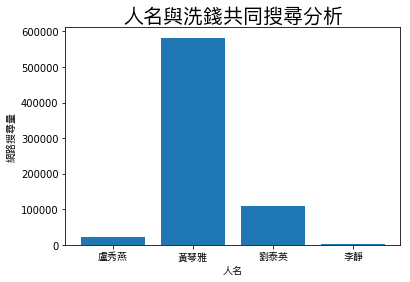

In [22]:
zhfont1 = fm.FontProperties(fname='/System/Library/Fonts/PingFang.ttc') 
key_name = ["盧秀燕","黃琴雅","劉泰英","李靜"]
x = [0,1,2,3]
x_label = "人名"
y_label = "網路搜尋量"
ax = plt.bar(key_name,Search_amount_0.values())
plt.xticks(x, key_name,fontproperties=zhfont1)
plt.title("人名與洗錢共同搜尋分析",fontproperties=zhfont1,fontsize = 20)
plt.xlabel(x_label,fontproperties=zhfont1)
plt.ylabel(y_label,fontproperties=zhfont1)


Text(0,0.5,'網路搜尋量')

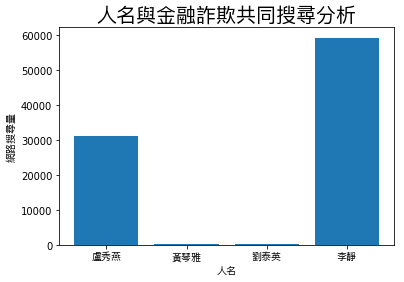

In [23]:
x = [0,1,2,3]
x_label = "人名"
y_label = "網路搜尋量"
bx = plt.bar(key_name,Search_amount_1.values())
plt.xticks(x, key_name,fontproperties=zhfont1)
plt.title("人名與金融詐欺共同搜尋分析",fontproperties=zhfont1,fontsize = 20)
plt.xlabel(x_label,fontproperties=zhfont1)
plt.ylabel(y_label,fontproperties=zhfont1)